<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#загружаю-данные" data-toc-modified-id="загружаю-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>загружаю данные</a></span></li><li><span><a href="#ресемплирую-данные-по-1-часу" data-toc-modified-id="ресемплирую-данные-по-1-часу-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ресемплирую данные по 1 часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

### загружаю данные

In [2]:
pth_df = '/datasets/taxi.csv'

if os.path.exists(pth_df):
    df = pd.read_csv(pth_df, index_col=[0], parse_dates=[0])
    print('файл успешно загружен')
    print(df.info())
else:
    print('файл не загружен')

файл успешно загружен
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


### ресемплирую данные по 1 часу

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

## Анализ

In [11]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [12]:
print('пропуски\n')
df.isna().sum()

пропуски



num_orders    0
dtype: int64

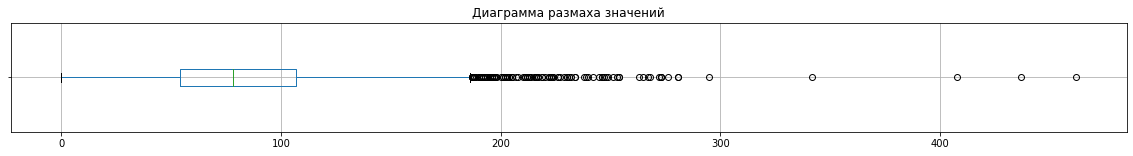

In [4]:
fig, ax = plt.subplots(figsize = (20,2))
ax = df.boxplot(vert = False, ax =ax)
ax.set_title(f'Диаграмма размаха значений')
plt.yticks([1], [''])
plt.plot();

In [5]:
decomposed = seasonal_decompose(df['num_orders'])

<AxesSubplot:xlabel='datetime'>

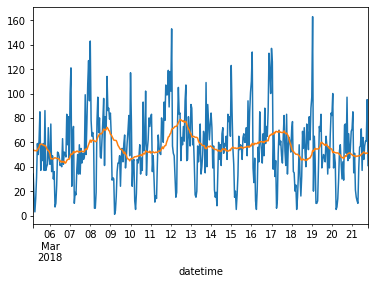

In [6]:
df['num_orders'].iloc[100:500].plot(ax=plt.gca())
df['num_orders'].rolling(24).mean().iloc[100:500].plot(ax=plt.gca())

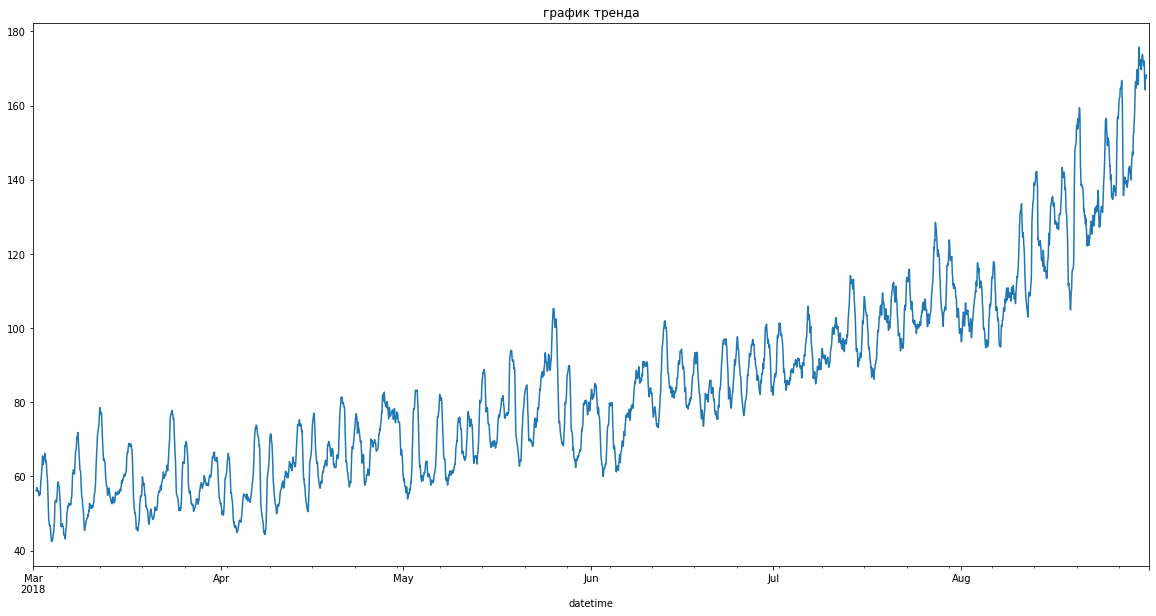

In [30]:
decomposed.trend.plot(ax=plt.gca(),figsize = (20,10))
plt.title('график тренда');

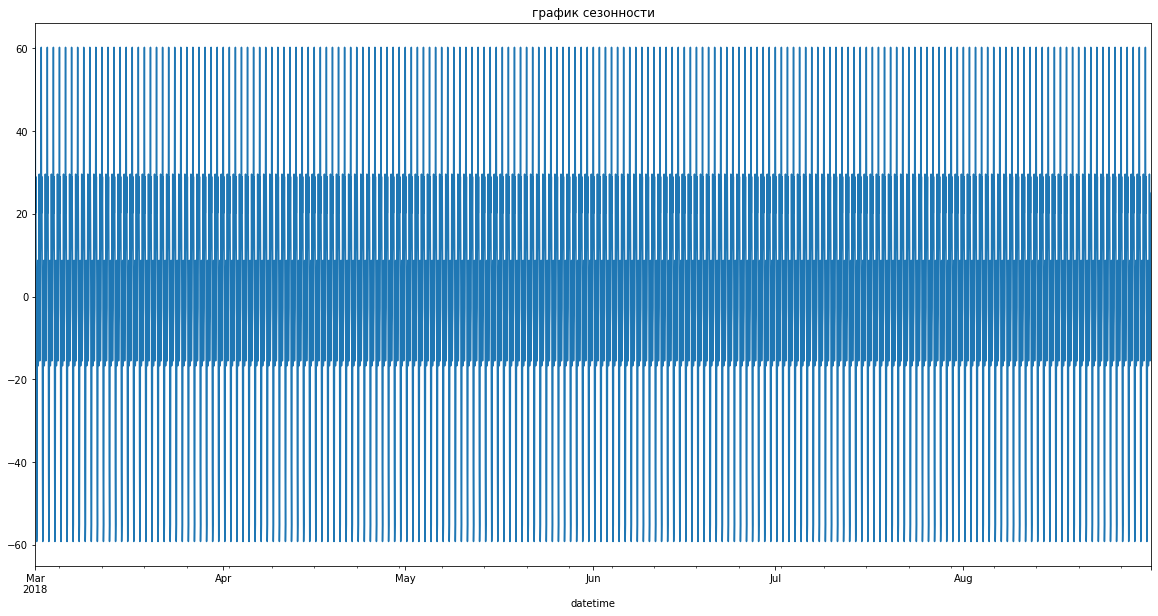

In [7]:
decomposed.seasonal.plot(ax=plt.gca(),figsize = (20,10))
plt.title('график сезонности');

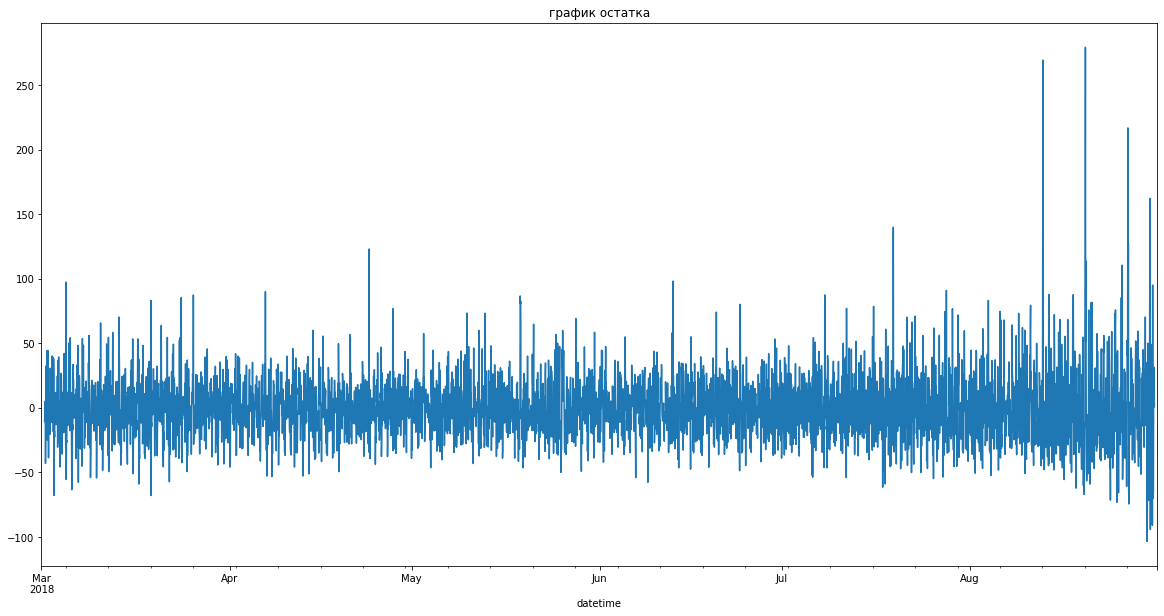

In [8]:
decomposed.resid.plot(ax=plt.gca(),figsize = (20,10))
plt.title('график остатка');

<AxesSubplot:xlabel='datetime'>

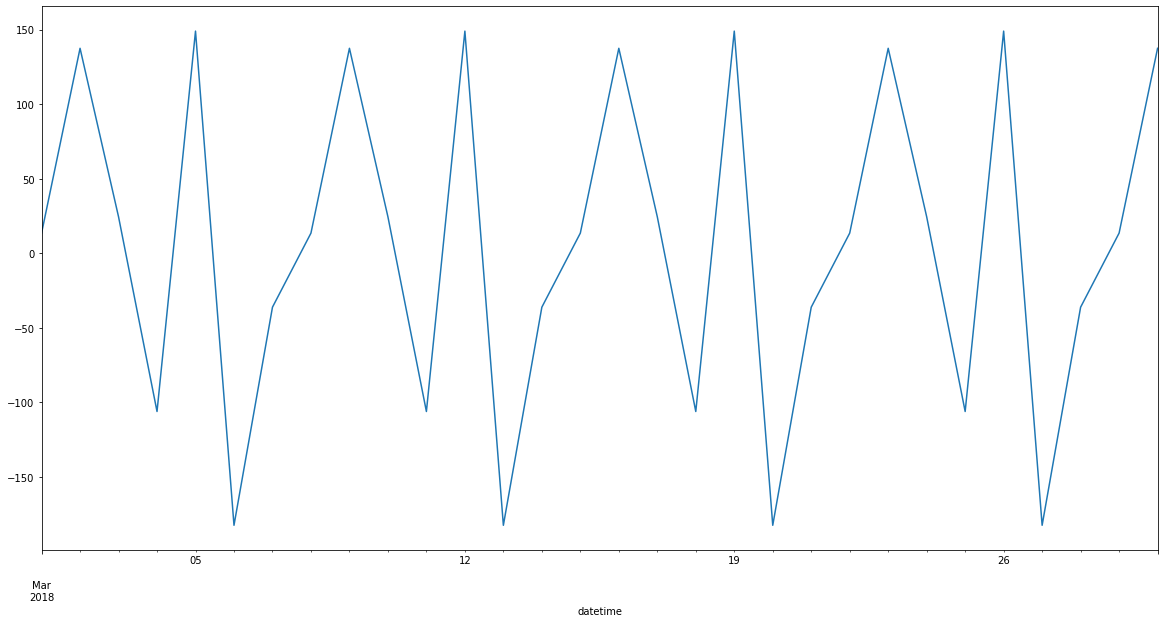

In [9]:
week = pd.read_csv(pth_df, index_col=[0], parse_dates=[0])
week.sort_index(inplace=True)
week = week.resample('1D').sum()
decomposed_week = seasonal_decompose(week['num_orders'])
decomposed_week.seasonal.iloc[0:30].plot(ax=plt.gca(),figsize = (20,10))

загружен, ресемплирован и проанализирован временной ряд.<br>
пропусков не обнаружено.<br>
временной ряд декомпозирован. выведены графики тренда, сезонности и остатка. временной ряд не является 100% стационарным.<br>
тренд не является постоянным, имеет участки мелких коррекций. так же имеет три участка с разным ускорением (март-июнь, июнь-конец июля, август)<br>
есть сезонность как дневная, так и недельная<br>
остатки так же неравномерны. в конце графика остатки больше, что скажется на точности модели на этапе тестирования

In [9]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

In [10]:
# создаю лаги и среднее скользящее
def make_features(data, max_lag, rolling_mean):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data[f'mean_{rolling_mean}'] = data['num_orders'].shift().rolling(rolling_mean).mean()
    
    return data

df = make_features(df, max_lag = 24, rolling_mean = 24)
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [11]:
df = df.dropna()
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [12]:
# целевой столбец- значение num_orders следующего часа
df['target'] = df['num_orders'].shift(-1)
df = df.dropna()

/tmp/ipykernel_31/3365998005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['num_orders'].shift(-1)


In [11]:
print('t-1=lag_1=',df['lag_1'].iloc[0])
print('t=',df['num_orders'].iloc[0])
print('t+1=target=',df['target'].iloc[0])

t-1=lag_1= 58.0
t= 90
t+1=target= 120.0


In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [15]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [16]:
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [17]:
cv = TimeSeriesSplit(n_splits=3).split(x_train)
model_lr = LinearRegression() 
score_lr = cross_val_score(model_lr, x_train, y_train, scoring='neg_mean_squared_error', cv=cv)

print("RMSE линейной регрессии:", round(np.mean(-score_lr)**0.5, 2))

RMSE линейной регрессии: 26.83


In [79]:
best_model_rf = None
best_result_rf = 100
best_est_rf = 0
best_depth_rf = 0
for est in range(10, 30, 2):
    print(est)
    for depth in range(10, 20, 2):
        model_rf = RandomForestRegressor(n_estimators=est, max_depth = depth)
        cv = TimeSeriesSplit(n_splits=3).split(x_train)
        score_rf = cross_val_score(model_rf, x_train, y_train, scoring='neg_mean_squared_error', cv=cv)
        result = round(np.mean(-score_rf)**0.5, 2)
        if result < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            best_est_rf = est
            best_depth_rf = depth

print("RMSE наилучшей модели случайного леса:", best_result_rf)
print('величина n_estimators:', best_est_rf, ' ,  max_depth:', best_depth_rf)

10
12
14
16
18
20
22
24
26
28
RMSE наилучшей модели случайного леса: 27.21
величина n_estimators: 26  ,  max_depth: 14


In [81]:
# ну и так, просто для смеха. кроссвалидацию сдесь не делал- не умею. да почти ничего здесь не умею)

model = Sequential()
model.add(Dense(10, activation='linear'))
model.add(Dense(10, activation='linear'))
model.add(Dense(10, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(
    loss='MeanSquaredError'
    , optimizer=Adam(learning_rate=0.07)
    
    , metrics=['accuracy']
)
model.fit(
    x_train
    , y_train
    , epochs=40
    , verbose=1
)

rmse_model = round(mean_squared_error(y_train, model.predict(x_train)) ** .5)
print('RMSE: ',rmse_model)


Epoch 1/40
124/124 [==============================] - 1s 3ms/step - loss: 10539.0410 - accuracy: 7.5930e-04
Epoch 2/40
124/124 [==============================] - 0s 4ms/step - loss: 888.0660 - accuracy: 7.5930e-04
Epoch 3/40
124/124 [==============================] - 0s 3ms/step - loss: 731.5264 - accuracy: 7.5930e-04
Epoch 4/40
124/124 [==============================] - 0s 3ms/step - loss: 700.9958 - accuracy: 7.5930e-04
Epoch 5/40
124/124 [==============================] - 0s 3ms/step - loss: 663.1763 - accuracy: 7.5930e-04
Epoch 6/40
124/124 [==============================] - 0s 3ms/step - loss: 693.4347 - accuracy: 7.5930e-04
Epoch 7/40
124/124 [==============================] - 0s 3ms/step - loss: 703.3792 - accuracy: 7.5930e-04
Epoch 8/40
124/124 [==============================] - 0s 3ms/step - loss: 682.9030 - accuracy: 7.5930e-04
Epoch 9/40
124/124 [==============================] - 0s 3ms/step - loss: 667.2316 - accuracy: 7.5930e-04
Epoch 10/40
124/124 [=======================

## Тестирование

In [90]:
model_lr.fit(x_train, y_train)
best_model_rf.fit(x_train, y_train)
model.fit(x_train, y_train,epochs=30,verbose=0)
print("RMSE LinearRegression на тестовой выборке:", mean_squared_error(y_test, model_lr.predict(x_test)) ** .5)
print("RMSE RandomForestRegressor на тестовой выборке:", mean_squared_error(y_test, best_model_rf.predict(x_test)) ** .5)
print("RMSE Dense_sequential_model на тестовой выборке:", mean_squared_error(y_test, model.predict(x_test)) ** .5)

RMSE LinearRegression на тестовой выборке: 43.51752545213749
RMSE RandomForestRegressor на тестовой выборке: 44.02935584031145
RMSE Dense_sequential_model на тестовой выборке: 45.60617634812918


In [91]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
print("RMSE тестовой выборки:", mean_squared_error(y_test, pred_previous) ** .5)

RMSE тестовой выборки: 58.97828953406191


<b>вывод:</b><br>
загружен, ресемплирован и проанализирован временной ряд.<br>
временной ряд декомпозирован. выведены графики тренда, сезонности и остатка. временной ряд не является 100% стационарным.<br>
тренд не является постоянным, имеет участки мелких коррекций. так же имеет три участка с разным ускорением<br>
есть сезонность как дневная, так и недельная<br>
остатки так же неравномерны. в конце графика остатки больше, что мешает тестированию модели<br>
обучены три модели: LinearRegression, RandomForestRegressor и Dense_sequential_model<br>
результаты сравнивались с константной моделью (предсказание по предыдущему значению). все три модели показали результат лучше.
наилучший результат показывает модель LinearRegression.<br>
RMSE= 43.5 что является лучшим результатом из представленных моделей и удовлетворяет условиям задачи